In [ ]:
# 구글 드라이브 로드
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Constants 정의

DATA_DIR = '/content/gdrive/My Drive/Kaggle/dog-breed-identification/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'
BATCH_SIZE = 64
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 897653

In [ ]:
# 라벨 불러오기

import pandas as pd

labels = pd.read_csv(DATA_DIR + 'labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


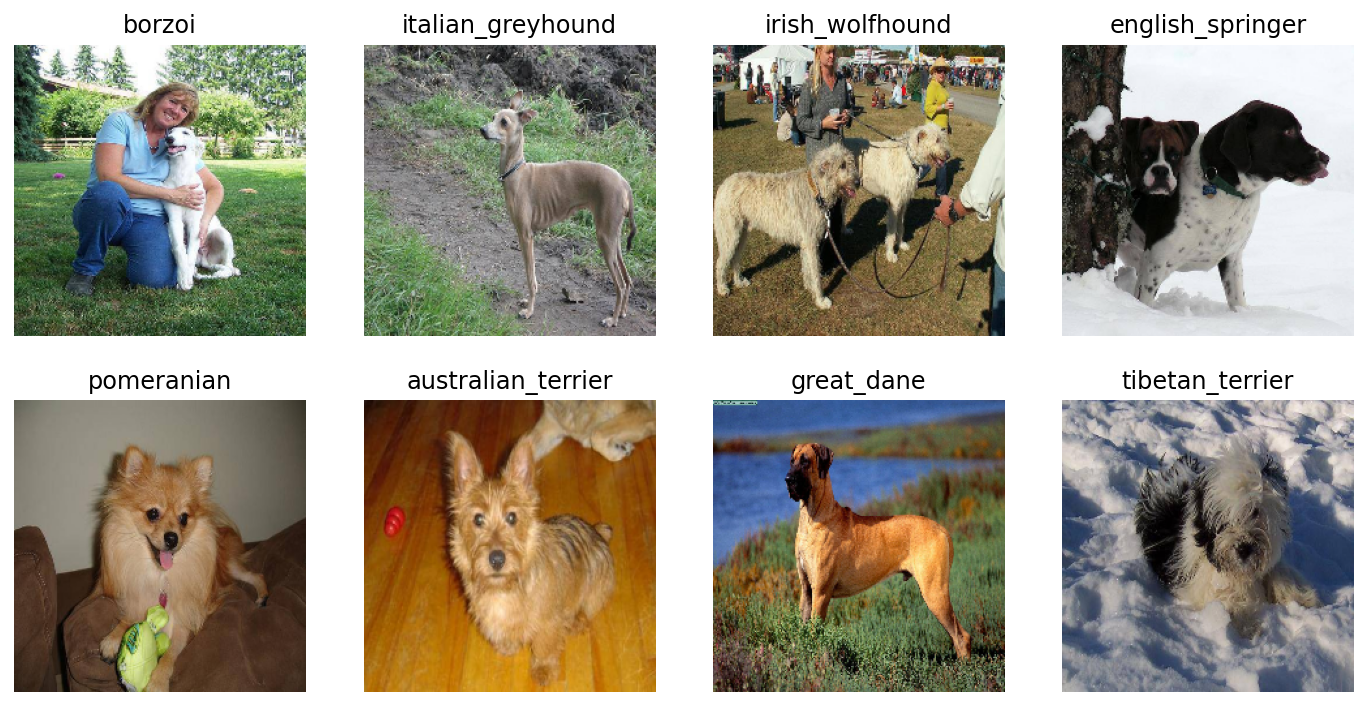

In [ ]:
# 미리 만들어두었던 데이터 가져오기

import numpy as np
import random
import matplotlib.pyplot as plt

xy_savez_compress_load = np.load('/content/gdrive/My Drive/Kaggle/dog-breed-identification/train.npz')
X = xy_savez_compress_load['x'] #
y = xy_savez_compress_load['y'] # one-hot encoding 적용
orig_label = xy_savez_compress_load['z'] # 적용 전 라벨
xy_savez_compress_load.close()

# 이미지 출력하기

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

n = len(labels)
breed = set(labels['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
n_class = len(breed)

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(orig_label[random_index])
    plt.axis('off')

In [ ]:
# 데이터 분할

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = labels['breed'], random_state = SEED)
X = []
y = []

In [ ]:
# 데이터 Augmentation

from imgaug import augmenters as iaa
import imgaug as ia
"""
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
    ]
)
"""

# 데이터 Gernerator

from keras.preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(preprocessing_function = seq.augment_image)

train_datagen = ImageDataGenerator(rotation_range = 30,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_train,
                                     y_train,                                 
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     seed = SEED)
valid_generator = val_datagen.flow(X_test,
                                  y_test,                                 
                                  batch_size = BATCH_SIZE,
                                  shuffle = False,
                                  seed = SEED)

# 불필요 배열 정리

steps_train = X_train.shape[0] // BATCH_SIZE
steps_test = X_test.shape[0] // BATCH_SIZE

X_train = []
X_test = []
y_train = []
y_test = []

In [ ]:
# 모델

#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG16, ResNet50, InceptionV3, InceptionResNetV2, Xception
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam, SGD

def create_model(learning_rate = 1e-5) :

  model = Sequential()

  base = InceptionResNetV2(include_top = False, weights = "imagenet", input_shape = (INPUT_SIZE, INPUT_SIZE, 3))
  #base.summary()


  # 레이어 Freeze

  for layer in base.layers : 
    layer.trainable = True # Freeze

  # 일부 레이어의 Freeze 해제

  """
  base.trainable = True # Freeze 해제

  set_trainable = False
  for layer in base.layers:
      if 'conv5' in layer.name :
          set_trainable = True
      if set_trainable:
          layer.trainable = True
      else:
          layer.trainable = False
  """

  # VGG 뒤에 레이어 추가
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(NUM_CLASSES, activation = 'softmax'))


  # 모델 컴파일

  #sgd = SGD(lr = 0.1, momentum = 0.95, nesterov = False)
  #model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  model.compile(optimizer = RMSprop(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['acc'])

  return model

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier


# 그리드 서치 구성
"""
#learning_rate = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
dropout = [0.0, 0.2, 0.3]
param_grids = dict(dropout = dropout)

model = KerasClassifier(build_fn = create_model, verbose = 0, batch_size = BATCH_SIZE, epochs = 10)

grid = GridSearchCV(estimator = model, param_grid = param_grids, cv = KFold(), verbose = 10)
grid_result = grid.fit(X_train, y_train)


# 그리드 서치 결과 출력

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))
"""

model = create_model(1e-5)
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               184440    
Total params: 54,521,176
Trainable params: 54,460,632
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
# 모델 학습
from keras.callbacks import EarlyStopping, ModelCheckpoint

callback_list = [
        EarlyStopping( #성능 향상이 멈추면 훈련을 중지
        monitor='val_acc',  #모델 검증 정확도를 모니터링
        patience=10          #1 에포크 보다 더 길게(즉, 2에포크 동안 정확도가 향상되지 않으면 훈련 중지
    ),
        ModelCheckpoint( #에포크마다 현재 가중치를 저장
        filepath="my_model.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True
    )
]


#history = model.fit(X, y, batch_size = BATCH_SIZE, epochs = 32, validation_split = 0.1)
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_train,
                              epochs = 32,
                              validation_data = valid_generator,
                              validation_steps = steps_test,
                              callbacks = callback_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/32
127/127 [==============================] - 152s 1s/step - loss: 4.7662 - acc: 0.0198 - val_loss: 4.3439 - val_acc: 0.0897
Epoch 2/32
127/127 [==============================] - 147s 1s/step - loss: 4.3976 - acc: 0.1048 - val_loss: 3.4467 - val_acc: 0.3468
Epoch 3/32
127/127 [==============================] - 147s 1s/step - loss: 3.8070 - acc: 0.2502 - val_loss: 2.3681 - val_acc: 0.5328
Epoch 4/32
127/127 [==============================] - 147s 1s/step - loss: 3.2124 - acc: 0.3434 - val_loss: 1.7345 - val_acc: 0.6310
Epoch 5/32
127/127 [==============================] - 147s 1s/step - loss: 2.7224 - acc: 0.4198 - val_loss: 1.3730 - val_acc: 0.6815
Epoch 6/32
127/127 [==============================] - 147s 1s/step - loss: 2.3560 - acc: 0.4729 - val_loss: 1.1589 - val_acc: 0.7147
Epoch 7/32
127/127 [==============================] - 147s 1s/step - loss: 2.0840 - acc: 0.5166 - val_loss: 1.0372 - val_acc: 

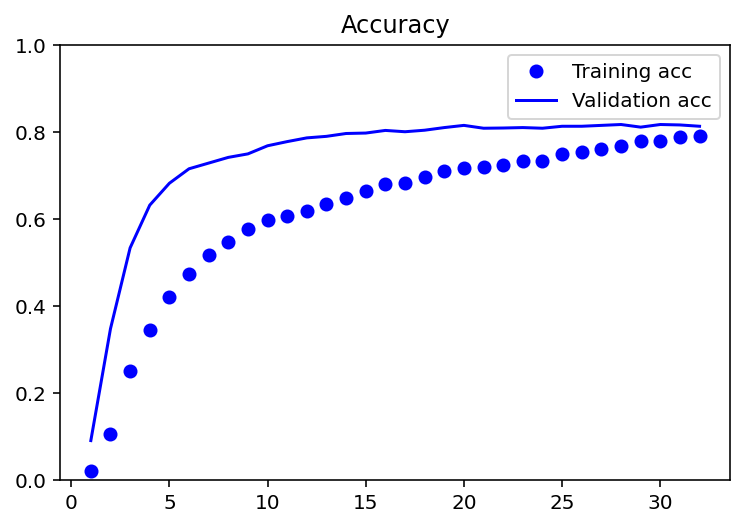

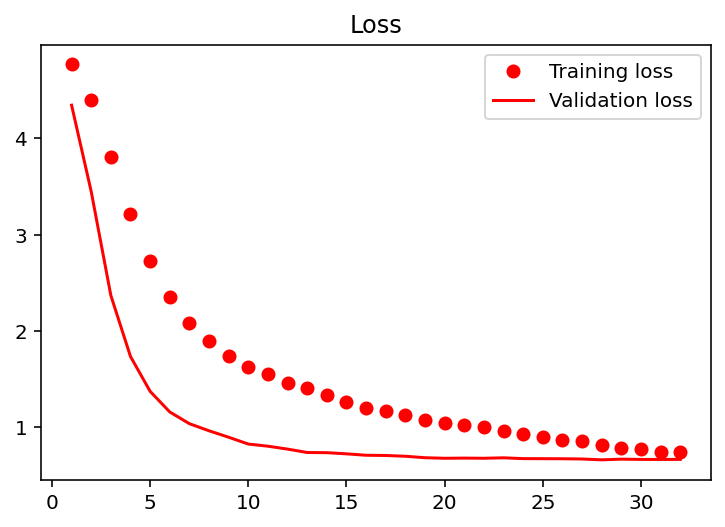

In [ ]:
# 학습 결과 확인

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [ ]:
#history = model.fit(X, y, batch_size = BATCH_SIZE, epochs = 32, validation_split = 0.1)
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_train,
                              epochs = 32,
                              validation_data = valid_generator,
                              validation_steps = steps_test,
                              callbacks = callback_list)

Epoch 1/32
127/127 [==============================] - 147s 1s/step - loss: 0.7255 - acc: 0.7930 - val_loss: 0.6843 - val_acc: 0.8145
Epoch 2/32
127/127 [==============================] - 148s 1s/step - loss: 0.7023 - acc: 0.7970 - val_loss: 0.6740 - val_acc: 0.8125
Epoch 3/32
127/127 [==============================] - 149s 1s/step - loss: 0.6827 - acc: 0.8081 - val_loss: 0.6821 - val_acc: 0.8085
Epoch 4/32
127/127 [==============================] - 149s 1s/step - loss: 0.6734 - acc: 0.8044 - val_loss: 0.6764 - val_acc: 0.8125
Epoch 5/32
127/127 [==============================] - 150s 1s/step - loss: 0.6426 - acc: 0.8161 - val_loss: 0.6803 - val_acc: 0.8191
Epoch 6/32
127/127 [==============================] - 151s 1s/step - loss: 0.6448 - acc: 0.8115 - val_loss: 0.6813 - val_acc: 0.8191
Epoch 7/32
127/127 [==============================] - 151s 1s/step - loss: 0.6196 - acc: 0.8210 - val_loss: 0.6928 - val_acc: 0.8100
Epoch 8/32
127/127 [==============================] - 151s 1s/step - 

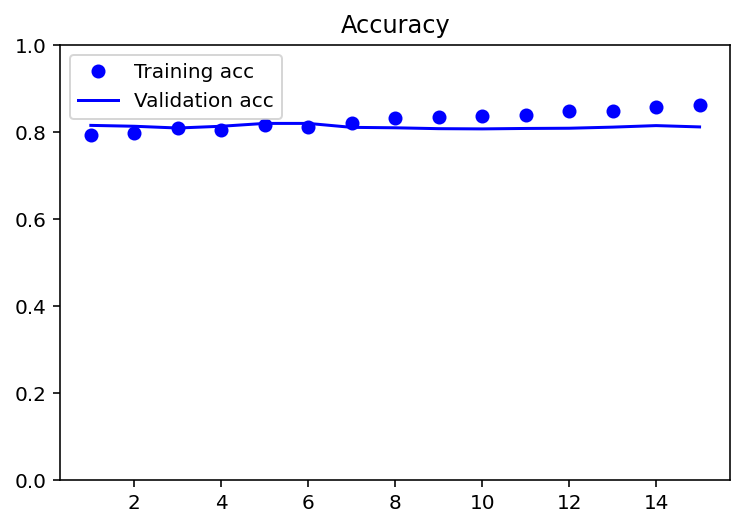

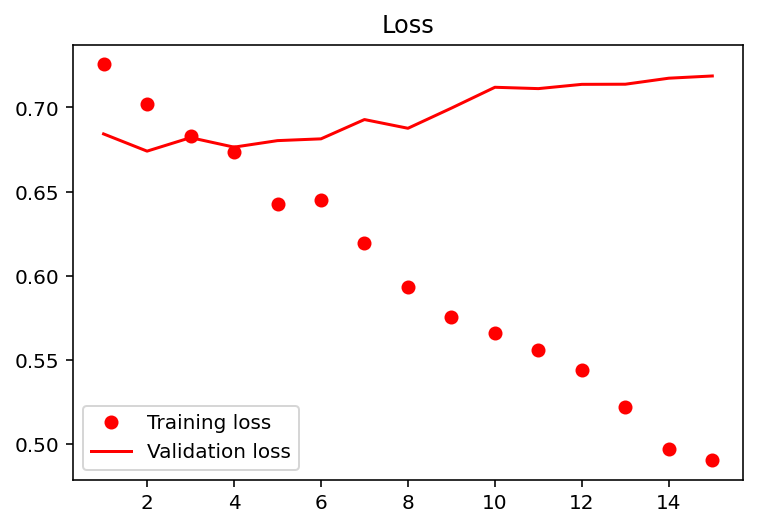

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [ ]:
xy_savez_compress_load = np.load('/content/gdrive/My Drive/Kaggle/dog-breed-identification/test.npz')
X_test = xy_savez_compress_load['x'] #
xy_savez_compress_load.close()

In [ ]:
X_test.shape

(10357, 224, 224, 3)

In [ ]:
y_pred = model.predict(X_test, batch_size = BATCH_SIZE)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[27 27 27 ... 27 27 27]
blenheim_spaniel  ->  96


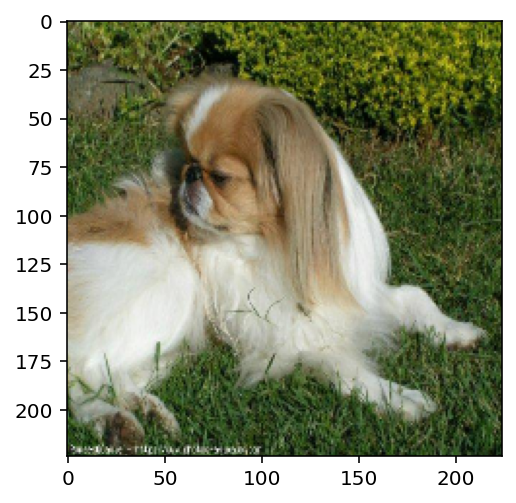

In [ ]:
plt.imshow(X_test[0][:,:,::-1])

print(y_pred)
idx_pred = np.where(y_pred > 0)
print(idx_pred[1])

for b in breed : 
  if (class_to_num[b] == 95 + 1) :
    print(b,' -> ', class_to_num[b])

In [ ]:
df_test = pd.read_csv(DATA_DIR + 'sample_submission.csv')

for b in breed : 
  df_test[b] = y_pred[:, class_to_num[b]]

df_test.to_csv('submission.csv', index = None)

In [ ]:
subm = pd.read_csv('submission.csv')
subm.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00102ee9d8eb90812350685311fe5890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0012a730dfa437f5f3613fb75efcd4ce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,001510bc8570bbeee98c8d80c8a95ec1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001a5f3114548acdefa3d4da05474c2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
